# Making a Diagonal Cross-Section of the Solomon Sea 
*Akira Di Sandro, 6/16/20*
<br>
In this notebook, I will be attempting to make a diagonal cross-section of the Solomon Sea as I want to be able to make one of the Solomon Strait to calculate transport there.

## 1. Import packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import xarray as xr
xr.set_options(display_style='html')
import intake
%matplotlib inline
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np

## 2. Import CM4 data from CMIP6 dataset

In [3]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)

In [4]:
dog = col.search(source_id='GFDL-CM4', experiment_id='historical', table_id='Omon', variable_id=['uo','vo','wo'], grid_label='gn')

In [5]:
dset_dict = dog.to_dataset_dict(zarr_kwargs={'consolidated': True})
list(dset_dict.keys())

Dataset(s):   0%|                                        | 0/1 [00:00<?, ?it/s]


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


Dataset(s): 100%|████████████████████████████████| 1/1 [00:00<00:00,  1.17it/s]


['CMIP.NOAA-GFDL.GFDL-CM4.historical.Omon.gn']

In [6]:
CM4_hist = dset_dict['CMIP.NOAA-GFDL.GFDL-CM4.historical.Omon.gn']
CM4_hist

<xarray.Dataset>
Dimensions:    (bnds: 2, lev: 35, member_id: 1, time: 1980, x: 1440, y: 1080)
Coordinates:
    lat        (y, x) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    time_bnds  (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
    lon        (y, x) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    lev_bnds   (lev, bnds) float64 dask.array<chunksize=(35, 2), meta=np.ndarray>
  * y          (y) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
  * x          (x) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * bnds       (bnds) float64 1.0 2.0
  * lev        (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
  * time       (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * member_id  (member_id) <U8 'r1i1p1f1'
Data variables:
    uo         (member_id, time, lev, y, x) float32 dask.array<chunksize=(1, 1, 35, 1080, 1440), meta=np.ndarray>
    vo         (member_id, time, lev, y, x) float32 dask.array<chunksize=(1, 1, 35, 1080, 1440), meta=np.ndarray>
Attributes:
    initialization_index:    1
    branch_method:           standard
    product:                 model-output
    branch_time_in_child:    0.0
    source:                  GFDL-CM4 (2018): \naerosol: interactive\natmos: ...
    parent_mip_era:          CMIP6
    references:              see further_info_url attribute
    comment:                 <null ref>
    parent_experiment_id:    piControl
    branch_time_in_parent:   36500.0
    contact:                 gfdl.climate.model.info@noaa.gov
    experiment:              historical
    parent_variant_label:    r1i1p1f1
    institution_id:          NOAA-GFDL
    sub_experiment:          none
    history:                 File was processed by fremetar (GFDL analog of C...
    nominal_resolution:      25 km
    Conventions:             CF-1.7 CMIP-6.0 UGRID-1.0
    realm:                   ocean
    realization_index:       1
    variant_label:           r1i1p1f1
    tracking_id:             hdl:21.14100/d0ebcd36-d2cd-442e-a8d9-8f7a27168a2...
    status:                  2019-08-06;created;by nhn2@columbia.edu
    grid:                    ocean data on native grid tripolar - nominal 0.2...
    frequency:               mon
    grid_label:              gn
    mip_era:                 CMIP6
    sub_experiment_id:       none
    parent_activity_id:      CMIP
    title:                   NOAA GFDL GFDL-CM4 model output prepared for CMI...
    parent_source_id:        GFDL-CM4
    source_type:             AOGCM
    experiment_id:           historical
    license:                 CMIP6 model data produced by NOAA-GFDL is licens...
    activity_id:             CMIP
    parent_time_units:       days since 0001-1-1
    source_id:               GFDL-CM4
    physics_index:           1
    institution:             National Oceanic and Atmospheric Administration,...
    forcing_index:           1
    variant_info:            N/A
    table_id:                Omon
    data_specs_version:      01.00.27
    further_info_url:        https://furtherinfo.es-doc.org/CMIP6.NOAA-GFDL.G...
    intake_esm_dataset_key:  CMIP.NOAA-GFDL.GFDL-CM4.historical.Omon.gn

## 3. Make Diagonal Cross section
### a. Find two points to draw diagonal

I will definitely need a dask cluster to do at least visualize the area I want to make the diagonal on.

In [7]:
from dask.distributed import Client
from dask_gateway import Gateway


gateway = Gateway()  # connect to Gateway

cluster = gateway.new_cluster()  # create cluster
cluster.scale(10)  # scale cluster

client = Client(cluster)  # connect Client to Cluster

In [8]:
client

Client Scheduler: gateway://traefik-ocean-prod-dask-gateway.ocean-prod:80/ocean-prod.1bf59029bdae4b59b322a2ad48e8cfd4 Dashboard: https://ocean.pangeo.io/services/dask-gateway/clusters/ocean-prod.1bf59029bdae4b59b322a2ad48e8cfd4/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [63]:
sol_map = CM4_hist['uo'].sel(member_id='r1i1p1f1',lev=2.5, time=CM4_hist.time[0]).sel(y=slice(-12.0,-2.0)).sel(x=slice(-215,-200))
sol_map

<xarray.DataArray 'uo' (y: 40, x: 61)>
dask.array<getitem, shape=(40, 61), dtype=float32, chunksize=(40, 61), chunktype=numpy.ndarray>
Coordinates:
    lat        (y, x) float32 dask.array<chunksize=(40, 61), meta=np.ndarray>
    lon        (y, x) float32 dask.array<chunksize=(40, 61), meta=np.ndarray>
    lev        float64 2.5
  * y          (y) float64 -11.91 -11.67 -11.42 -11.18 ... -2.749 -2.499 -2.249
    time       object 1850-01-16 12:00:00
  * x          (x) float64 -214.9 -214.7 -214.4 -214.2 ... -200.5 -200.3 -200.0
    member_id  <U8 'r1i1p1f1'
Attributes:
    cell_methods:   time: mean
    interp_method:  none
    long_name:      Sea Water X Velocity
    original_name:  uo
    standard_name:  sea_water_x_velocity
    units:          m s-1

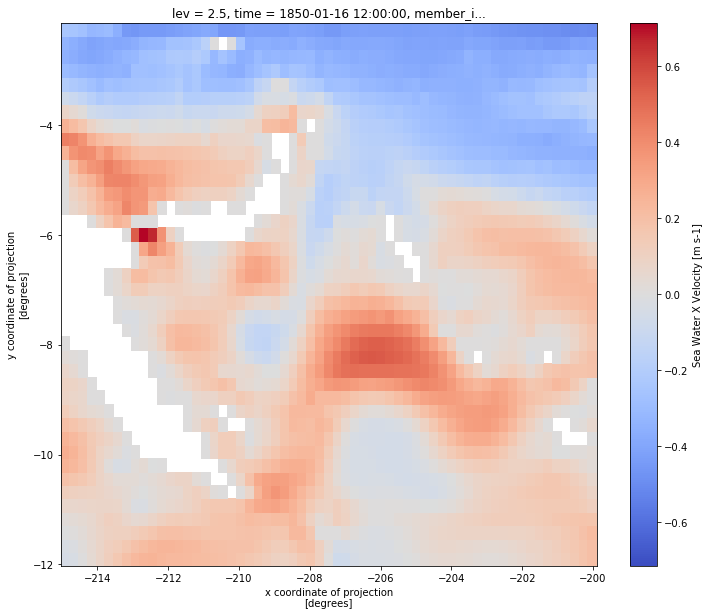

In [67]:
myorigplot = sol_map.plot(cmap='coolwarm', figsize=[12, 10])

* Let's say I want to make a diagonal line from (-211, -7) to (-204, -10).

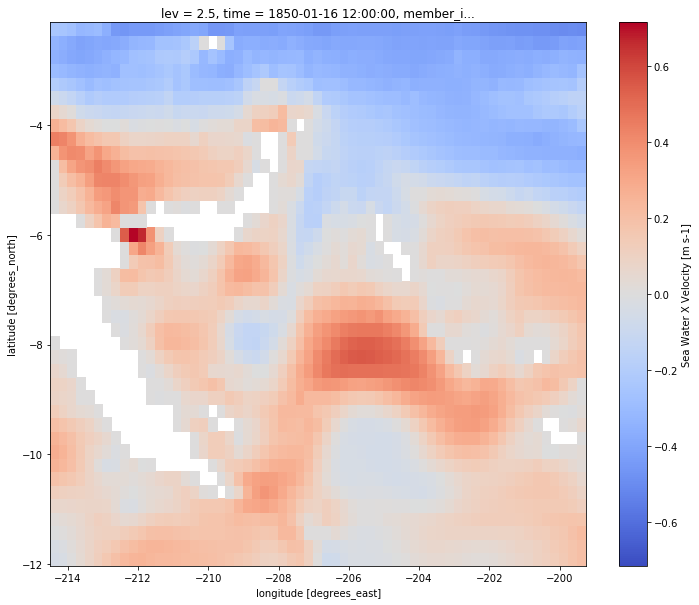

In [68]:
rafeditplot = sol_map.plot(x='lon', y='lat', cmap='coolwarm', figsize=[12, 10])

In [ ]:
#seeing the original plot i had side by side with the edit raf pointed out
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Horizontally stacked subplots')
ax1.plot(x, y)
ax2.plot(x, -y)

In [20]:
diag_cs = CM4_hist.sel(time='2012').mean(dim='time').sel(member_id='r1i1p1f1', y=slice(-10.0,-7.0)).sel(x=slice(-211,-204))
diag_cs

<xarray.Dataset>
Dimensions:    (bnds: 2, lev: 35, x: 28, y: 12)
Coordinates:
    lev_bnds   (lev, bnds) float64 dask.array<chunksize=(35, 2), meta=np.ndarray>
    lat        (y, x) float32 dask.array<chunksize=(12, 28), meta=np.ndarray>
    lon        (y, x) float32 dask.array<chunksize=(12, 28), meta=np.ndarray>
  * bnds       (bnds) float64 1.0 2.0
  * lev        (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
  * y          (y) float64 -9.95 -9.703 -9.457 -9.21 ... -7.726 -7.479 -7.231
  * x          (x) float64 -210.9 -210.7 -210.4 -210.2 ... -204.7 -204.5 -204.2
    member_id  <U8 'r1i1p1f1'
Data variables:
    uo         (lev, y, x) float32 dask.array<chunksize=(35, 12, 28), meta=np.ndarray>
    vo         (lev, y, x) float32 dask.array<chunksize=(35, 12, 28), meta=np.ndarray>

* Selecting and labeling the two end points of the diagonal I want to draw

In [15]:
#define starting point of diagonal as the top left point, (-211,-7)
startpt = [float(diag_cs.x[0]), float(diag_cs.y[-1])]
#define end point of diagonal as the bottom right point, (-202,-10)
endpt = [float(diag_cs.x[-1]), float(diag_cs.y[0])]
print('starting point is ', startpt, ' and ending point is ', endpt)

starting point is  [-210.941085506949, -7.230729913178203]  and ending point is  [-204.24186991197521, -9.949613673872904]


### b. Define points on diagonal line.

In [25]:
#for now, basing it off the data i'm currently working with
latdif = abs(startpt[1]-endpt[1])
londif = abs(startpt[0]-endpt[0])
latlonfrac = latdif/londif
#number of evenly spaced points I want
numpt = 10
latspace = latdif/numpt
lonspace = londif/numpt

In [41]:
#create (random) data array for points on diagonal
zerodata = np.zeros(shape=(numpt+1,numpt+1,35))
lat = np.zeros(numpt+1)
lon = np.zeros(numpt+1)

In [42]:
#specify values of lat and lon in points
for i in range(numpt +1):
    lat[i] = startpt[1]-i*latspace
for i in range(numpt +1):
    lon[i] = startpt[0]+i*lonspace

In [43]:
lev = diag_cs.lev.data

In [44]:
dim3 = ['lat', 'lon', 'lev']
points = xr.DataArray(zerodata, coords=[lat, lon, lev], dims=['lat', 'lon', 'lev'])
points

<xarray.DataArray (lat: 11, lon: 11, lev: 35)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * lat      (lat) float64 -7.231 -7.503 -7.775 -8.046 ... -9.406 -9.678 -9.95
  * lon      (lon) float64 -210.9 -210.3 -209.6 -208.9 ... -205.6 -204.9 -204.2
  * lev      (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03

'points' is a data array that has the different lat and lon that i'm interested with depth (lev) as the third dimension. I want to use interp3d to interpolate the 'uo' data into this points data.

## 4. Interpolate existing 'uo' data on to the points on diagonal

In [45]:
from scipy import interpolate

### a. Defining Variables

In [54]:
diag_cs.uo.data

dask.array<getitem, shape=(35, 12, 28), dtype=float32, chunksize=(35, 12, 28), chunktype=numpy.ndarray>

In [38]:
# xg = given x: x array from diag cs of CM4 ---- yg = given y: y array from diag cs of CM4
xg = diag_cs.x.data
yg = diag_cs.y.data
xx, yy = np.meshgrid(xg, yg)
zg = diag_cs.uo.data

In [39]:
f = interpolate.interp2d(xg, yg, zg, kind='cubic')

The above code gives the error "x and y must have equal lengths for non rectangular grid" for xg, yg, zg as inputs for interpolate. But what if I want a rectangular grid? Maybe because it's scipy arrays and not np array
<br> The above code gives the error "Invalid length for input z for non rectangular grid" for xx, yy, zg as inputs for interpolate.

## 5. Finding theta between diagonal and vertical lines

I need haversine for this. Theta will be in radians.

In [35]:
from haversine import haversine, Unit
import math

In [31]:
dtop = [float(diag_cs.y[-1]), float(diag_cs.x[0])] #top of diag in (lat, lon) format
dbot = [float(diag_cs.y[0]), float(diag_cs.x[-1])] #bottom of diag and vertical in (lat, lon) format
vtop = [float(diag_cs.y[-1]), float(diag_cs.x[-1])] #top of vertical in (lat, lon) format

In [39]:
ddist = haversine(dtop, dbot) #distance between dtop and dbot
vdist = haversine(dbot, vtop) #distance between dbot and vdist

theta = math.acos(vdist/ddist)
#theta, math.degrees(theta)

### Close cluster at the end

In [11]:
client.close()
cluster.close()